<a href="https://colab.research.google.com/github/joordonezo-other-project/clasificadorDeArepas/blob/dev/Clasificador_de_arepas_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip '/content/drive/MyDrive/Trabajo De Grado/arepasDataset.zip' -d ./

Archive:  /content/drive/MyDrive/Trabajo De Grado/arepasDataset.zip
   creating: ./arepasDataset/defectuosas/
  inflating: ./arepasDataset/defectuosas/IMG_20230820_171433084.jpg  
  inflating: ./arepasDataset/defectuosas/IMG_20230820_171442075.jpg  
  inflating: ./arepasDataset/defectuosas/IMG_20230820_171451984.jpg  
  inflating: ./arepasDataset/defectuosas/IMG_20230820_171509307.jpg  
  inflating: ./arepasDataset/defectuosas/IMG_20230820_171517017.jpg  
  inflating: ./arepasDataset/defectuosas/IMG_20230820_171523813.jpg  
  inflating: ./arepasDataset/defectuosas/IMG_20230820_171530276.jpg  
  inflating: ./arepasDataset/defectuosas/IMG_20230820_171544164.jpg  
  inflating: ./arepasDataset/defectuosas/IMG_20230820_171552728.jpg  
  inflating: ./arepasDataset/defectuosas/IMG_20230820_171558822.jpg  
  inflating: ./arepasDataset/defectuosas/IMG_20230820_171605668.jpg  
  inflating: ./arepasDataset/defectuosas/IMG_20230820_171612396.jpg  
  inflating: ./arepasDataset/defectuosas/IMG_20230

In [ ]:
!pip install onnx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 44.5 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
from torch import optim
import torch.onnx
import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

<ipython-input-3-ce7e2e3cd421>:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  plt.imshow(img.T)


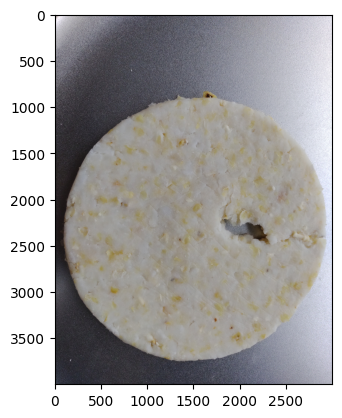

In [ ]:
img = read_image('./arepasDataset/defectuosas/IMG_20230820_173228909.jpg')
plt.imshow(img.T)
plt.show()

In [ ]:
img.shape

torch.Size([3, 3000, 4000])

In [ ]:
img.dtype

torch.uint8

In [ ]:
img[:,100:102,100:102]

tensor([[[183, 187],
         [196, 192]],

        [[181, 185],
         [194, 190]],

        [[186, 190],
         [199, 195]]], dtype=torch.uint8)

In [ ]:
# Define la transformación para cambiar el tamaño de las imágenes
resize_transform = transforms.Compose([
    transforms.Resize((120, 160)),
    transforms.ToTensor(),  # Convierte la imagen a un tensor
])

In [ ]:
dataset_path = './arepasDataset'

In [ ]:
# Carga los datos utilizando ImageFolder y aplica la transformación
dataset = ImageFolder(dataset_path, transform=resize_transform)
# Convierte las etiquetas del conjunto de entrenamiento a formato one-hot
num_classes = 2  # Dos clases en clasificación binaria
dataset.targets = F.one_hot(torch.tensor(dataset.targets), num_classes=num_classes).float()

In [ ]:
# Define el tamaño del lote
batch_size = 64
# Crea el DataLoader
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Calcula el tamaño del conjunto de prueba (20%)
total_size = len(dataset)
test_size = int(0.2 * total_size)
train_size = total_size - test_size

# Divide el dataset en conjunto de entrenamiento y conjunto de prueba
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Crea DataLoaders separados para entrenamiento y prueba
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
test_dataset.dataset.targets.shape

torch.Size([454, 2])

torch.Size([64, 3, 120, 160])
torch.Size([64])


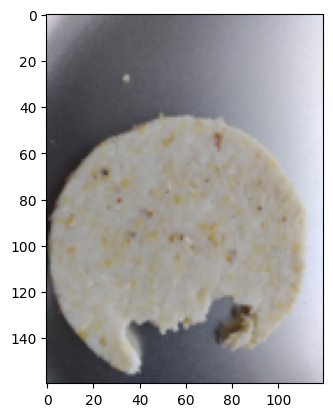

In [ ]:
for batch in train_loader:
    images, labels = batch  # Separa las imágenes y las etiquetas

    # Imprime el tamaño (shape) de las imágenes en el lote actual
    print(images.shape)
    print(labels.shape)
    plt.imshow(images[0].T)
    # Puedes detener la iteración después de imprimir el primer lote si solo quieres ver un ejemplo
    break
plt.show()

In [ ]:
def plot_loss(train_losses, test_losses):
    plt.figure(figsize=(12, 4))
    plt.plot(train_losses, label='Pérdida de entrenamiento', color='blue')
    plt.plot(test_losses, label='Pérdida de prueba', color='red')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.title('Curva de Pérdida')
    plt.grid(True)
    plt.show()

def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 4))
    plt.plot(train_accuracies, label='Precisión de entrenamiento', color='blue')
    plt.plot(test_accuracies, label='Precisión de prueba', color='red')
    plt.xlabel('Época')
    plt.ylabel('Precisión (%)')
    plt.legend()
    plt.title('Curva de Precisión')
    plt.grid(True)
    plt.show()

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3,64, kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(128*30*40, 256),
    nn.ReLU(),

    nn.Linear(256, 1),
    nn.Sigmoid()

)
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=153600, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=1, bias=True)
  (10): Sigmoid()
)


In [ ]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizador Adam


In [ ]:
def train(model, num_epochs, train_dl, valid_dl):
  loss_hist_train = [0] * num_epochs
  acurracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  acurracy_hist_valid = [0] * num_epochs

  for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_dl:
      pred = model(x_batch)[:,0]
      loss = loss_fn(pred, y_batch.float())
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()*y_batch.size(0)
      is_correct = ((pred>=0.5).float() == y_batch).float()
      acurracy_hist_train[epoch] += is_correct.sum()
    loss_hist_train[epoch] /= len(train_dl.dataset)
    acurracy_hist_train[epoch] /= len(train_dl.dataset)

    model.eval()
    with torch.no_grad():
      for x_batch, y_batch in valid_dl:
        pred = model(x_batch)[:,0]
        loss = loss_fn(pred, y_batch.float())
        loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
        is_correct = ((pred>=0.5).float() == y_batch).float()
        acurracy_hist_valid[epoch] += is_correct.sum()
    loss_hist_valid[epoch] /= len(valid_dl.dataset)
    acurracy_hist_valid[epoch] /= len(valid_dl.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}] accuracy_train: '
          f'{acurracy_hist_train[epoch]:.4f} accuracy_test: '
          f'{acurracy_hist_valid[epoch]:.4f}')
  return loss_hist_train, loss_hist_valid, acurracy_hist_train, acurracy_hist_valid

Epoch [1/27] accuracy_train: 0.5302 accuracy_test: 0.5111
Epoch [2/27] accuracy_train: 0.4615 accuracy_test: 0.5111
Epoch [3/27] accuracy_train: 0.6016 accuracy_test: 0.8556
Epoch [4/27] accuracy_train: 0.8159 accuracy_test: 0.8778
Epoch [5/27] accuracy_train: 0.7747 accuracy_test: 0.8111
Epoch [6/27] accuracy_train: 0.8489 accuracy_test: 0.8778
Epoch [7/27] accuracy_train: 0.8819 accuracy_test: 0.8778
Epoch [8/27] accuracy_train: 0.9148 accuracy_test: 0.8778
Epoch [9/27] accuracy_train: 0.9231 accuracy_test: 0.9000
Epoch [10/27] accuracy_train: 0.9011 accuracy_test: 0.8444
Epoch [11/27] accuracy_train: 0.8709 accuracy_test: 0.9000
Epoch [12/27] accuracy_train: 0.8956 accuracy_test: 0.8333
Epoch [13/27] accuracy_train: 0.8599 accuracy_test: 0.8556
Epoch [14/27] accuracy_train: 0.8544 accuracy_test: 0.9111
Epoch [15/27] accuracy_train: 0.9066 accuracy_test: 0.8889
Epoch [16/27] accuracy_train: 0.9478 accuracy_test: 0.9111
Epoch [17/27] accuracy_train: 0.9670 accuracy_test: 0.9000
Epoch 

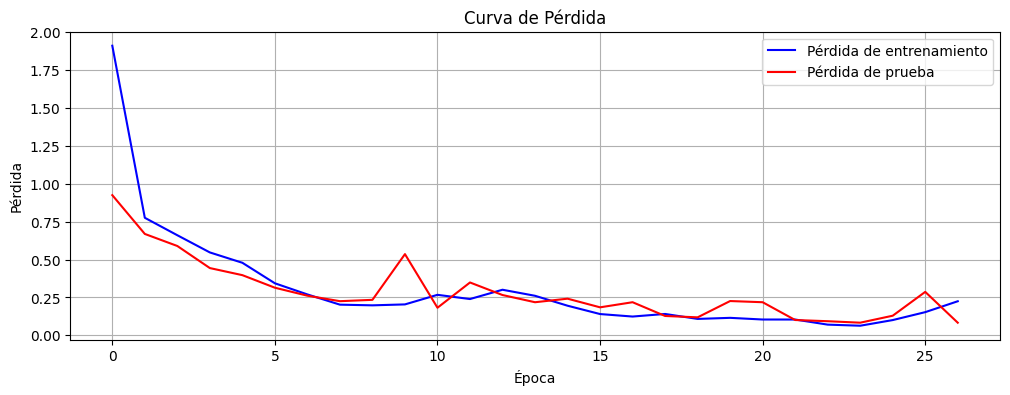

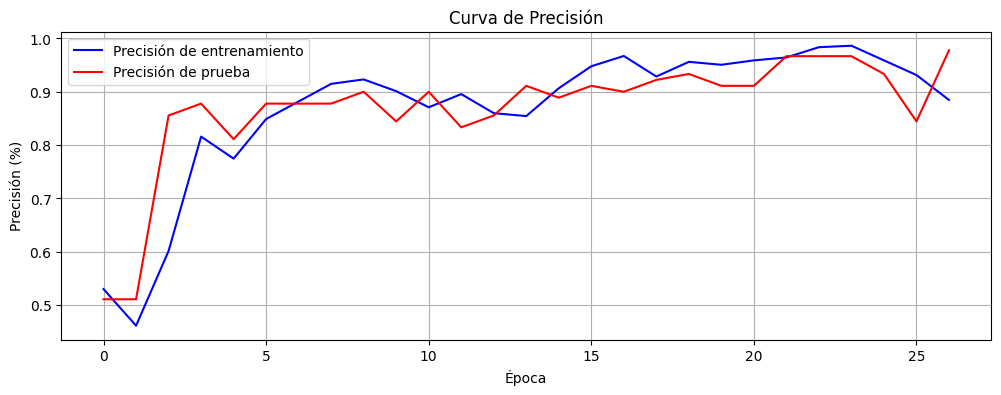

In [ ]:
num_epochs = 27
train_losses, test_losses, train_accuracies, test_accuracies = train(model, num_epochs, train_loader, test_loader)

plot_loss(train_losses, test_losses)
plot_accuracy(train_accuracies, test_accuracies)

In [ ]:
x = torch.rand(64,3,120,160)
y = model.cpu()(x)

torch.onnx.export(model,
                  x,
                  "model.onnx",
                  export_params=True,
                  opset_version=10,
                  do_constant_folding=True,
                  input_names = ['input'],
                  output_names = ['output'],
                  dynamic_axes={
                      'input':{
                          0:'batch_size'
                      },
                      'output':{
                          0:'batch_size'
                      }
                  })

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
import onnx

onnx_model = onnx.load("model.onnx")
onnx.checker.check_model(onnx_model)

In [ ]:
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.5 MB/s eta 0:00:00


In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("model.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(y), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


In [ ]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((120, 160)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)

    return image

def predict_image(onnx_model_path, image_path):
    ort_session = onnxruntime.InferenceSession(onnx_model_path)

    image = preprocess_image(image_path)
    image_np = image.numpy()

    ort_inputs = {ort_session.get_inputs()[0].name: image_np}
    ort_outs = ort_session.run(None, ort_inputs)

    prediction = ort_outs[0][0]

    if prediction >= 0.5:
        return "Arepa Perfecta"
    else:
        return "Arepa Defectuosa"

In [ ]:
onnx_model_path = "model.onnx"
image_path = "/content/arepasDataset/perfectas/IMG_20230820_160905452(1).jpg"
result = predict_image(onnx_model_path, image_path)
print(f"Predicción para la imagen {image_path}: {result}")

Predicción para la imagen /content/arepasDataset/perfectas/IMG_20230820_160905452(1).jpg: Arepa Perfecta
